# Bank Account Assessment Project Part 6
#### Missing data imputation, financial analysis, and project completion.

From the models used and their ROC AUC result:  
Logistic Regression with lasso regularization    = 0.718  
Logistic Regression with features engineering    = 0.740  
Decision Tree                                    = 0.745  
Random Forest                                    = 0.776

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

In [2]:
# using the original dataset to imput the missing data
df_orig = pd.read_excel("Credit_card_clients.xls")

In [3]:
df_zero_mask = df_orig == 0
feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)
sum(feature_zero_mask)

315

In [4]:
df_clean = df_orig.loc[~feature_zero_mask, :].copy()
df_clean.shape

(29685, 25)

In [5]:
# verify for not unique values in ID
df_clean["ID"].nunique()

29685

In [6]:
df_clean["EDUCATION"].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean["MARRIAGE"].replace(to_replace=0, value=3, inplace=True)

# the value that appears the most is zero
df_clean["PAY_1"].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [7]:
missing_pay_1_mask = df_clean["PAY_1"] == 'Not available'
sum(missing_pay_1_mask)

3021

In [8]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask, :].copy()
df_missing_pay_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
17,f0ba5e02-0c0f,320000,1,1,1,49,Not available,0,0,-1,...,70074,5856,195599,10358,10000,75940,20000,195599,50000,0
28,aecb449b-a999,50000,2,3,1,47,Not available,-1,-1,-1,...,2040,30430,257,3415,3421,2044,30430,257,0,0
29,57ea9a1f-cdd5,50000,1,1,2,26,Not available,0,0,0,...,17907,18375,11400,1500,1500,1000,1000,1600,0,0
54,781f3cc2-7ddc,150000,2,1,2,29,Not available,0,0,0,...,26518,21042,16540,1600,1718,1049,1500,2000,5000,0
60,5c00d7e6-a804,500000,2,3,1,28,Not available,0,0,0,...,14937,13827,15571,1516,1300,1000,1000,2000,2000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29949,4b490335-91ab,280000,1,1,1,39,Not available,0,0,0,...,40939,44290,70573,1652,2144,1666,5015,32013,12,0
29956,b4a99d86-3bdd,150000,1,1,2,30,Not available,0,0,-1,...,1610,1180,2980,2000,2000,2000,1000,3000,0,0
29967,f411fbb3-adaf,50000,1,2,1,32,Not available,0,0,-1,...,50551,40590,39384,2686,0,50551,0,1600,1500,0
29973,31c0c152-e5ac,230000,1,2,1,35,Not available,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# load clean data
df = pd.read_csv("Chapter_1_cleaned_data.csv")
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [10]:
features_response = df.columns.tolist()

items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT',
                  'graduate school', 'high school', 'none', 'others', 'university']

features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

### Imputing PAY_1 feature

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df[features_response[: -1]].values,
                                                   df['default payment next month'].values,
                                                   test_size=0.2, random_state=24)

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(features_response[4])

(21331, 17)
(5333, 17)
(21331,)
(5333,)
PAY_1


In [13]:
# median of non-missing values of PAY_1
np.median(x_train[:, 4])

0.0

In [14]:
# create list of values to test imputation
np.random.seed(seed=1)
fill_values = [0, np.random.choice(x_train[:, 4], size=(3021,), replace=True)]
fill_strategy = ['mode', 'random']
fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)

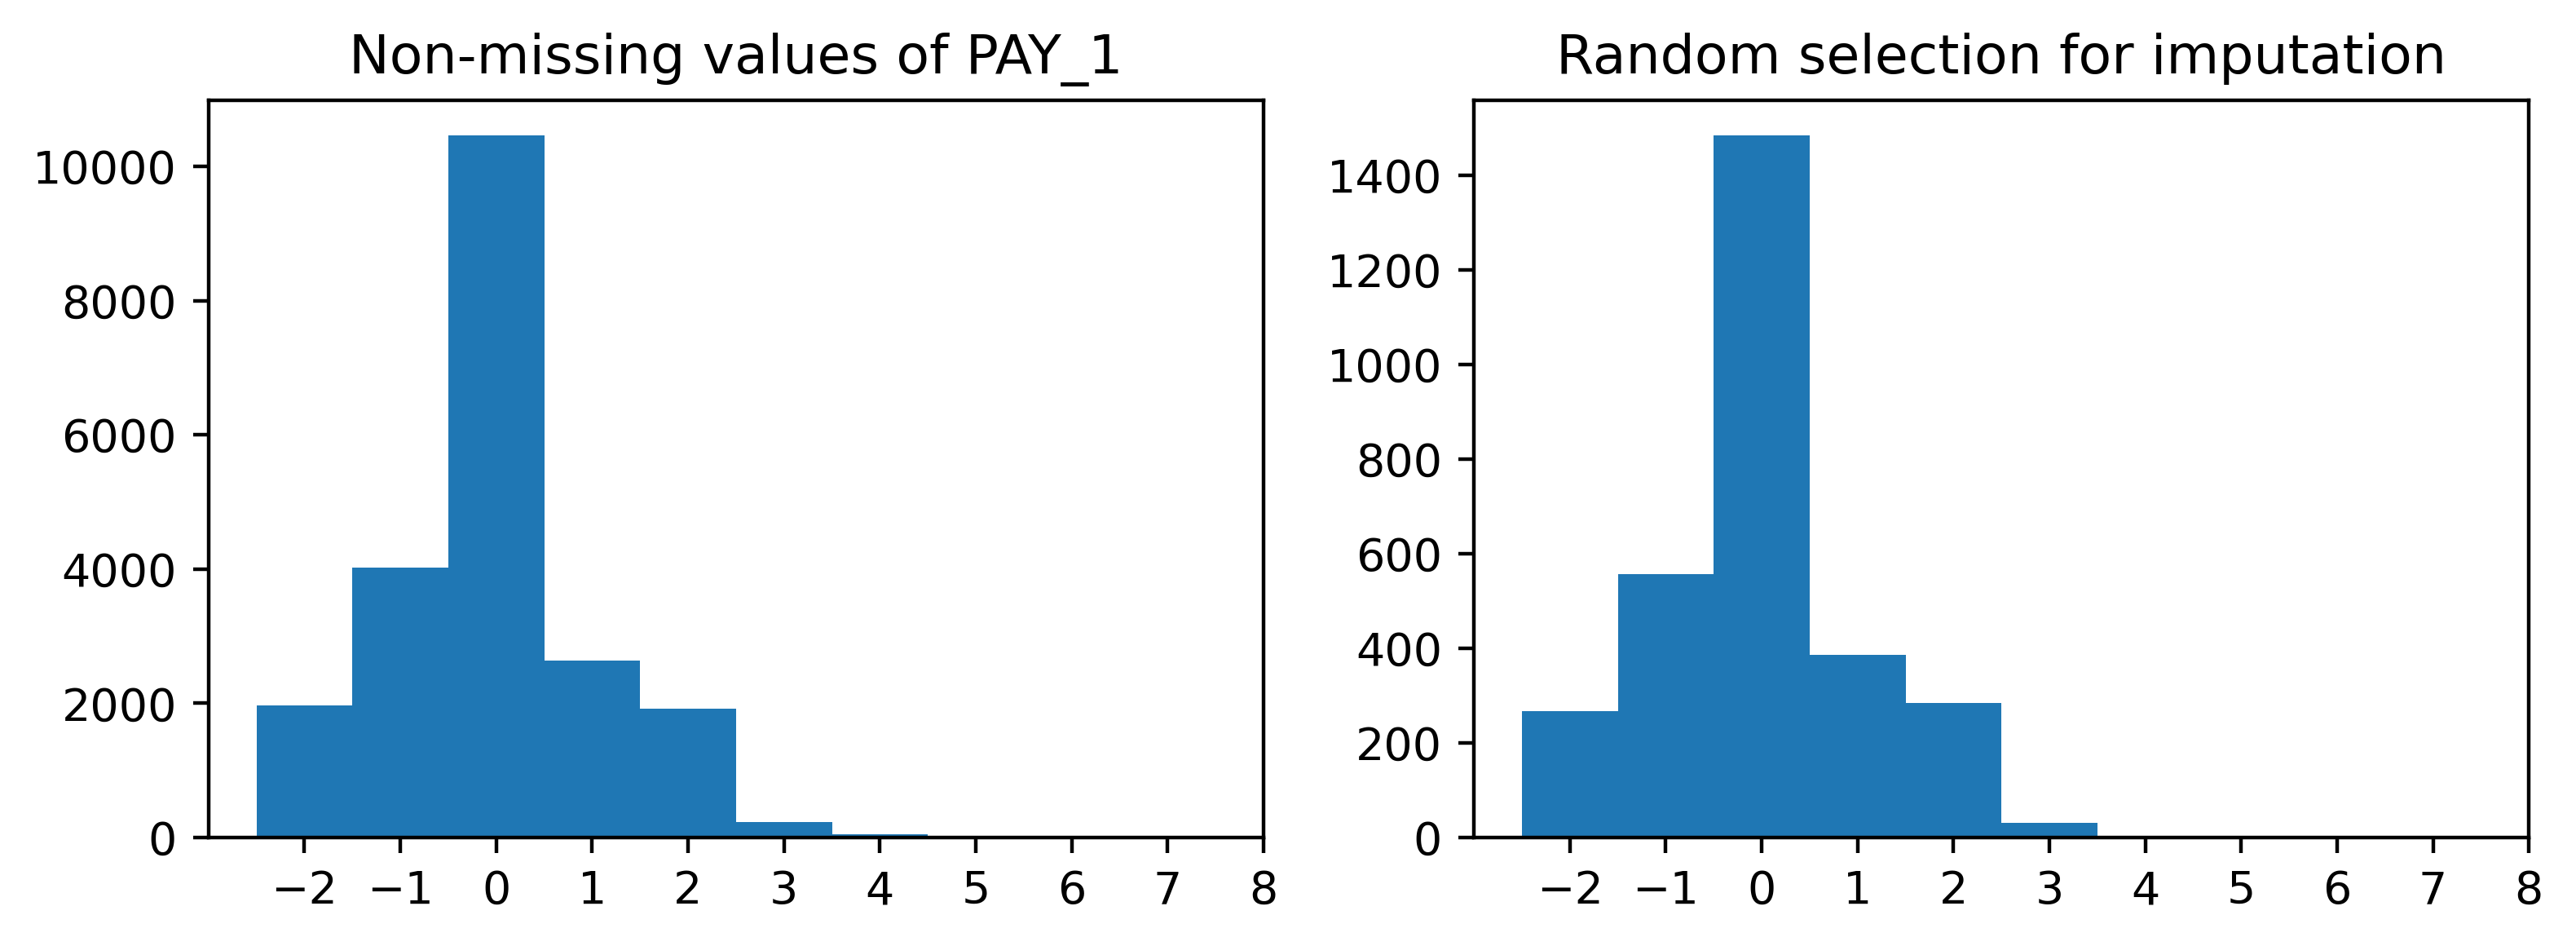

In [15]:
# plot histograms
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
bin_edges = np.arange(-2, 9)
axs[0].hist(x_train[:, 4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

In [16]:
from sklearn.model_selection import KFold

k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

In [18]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=9,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                           max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                           bootstrap=True, oob_score=False, n_jobs=None,
                           random_state=4, verbose=1, warm_start=False, class_weight=None)

In [19]:
# cross validation
for counter in range(len(fill_values)):
    
    # copy df and imput missing data
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    
    # divide imput data in train and test using 80/20 division
    x_fill_pay_1_train, x_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(df_fill_pay_1_filled[features_response[:-1]].values,
                    df_fill_pay_1_filled['default payment next month'].values,
                    test_size=0.2, random_state=24)
    
    # combine imputed data with non-missing values in PAY_1
    x_train_all = np.concatenate((x_train, x_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    
    # use KFold and random forest to obtain cross validation for all
    # the 4 folds using both imputation methods
    imputation_compare_cv = cross_validate(rf, x_train_all, y_train_all,
                                          scoring='roc_auc', cv=k_folds, n_jobs=-1,
                                          verbose=1, return_train_score=True,
                                          return_estimator=True, error_score='raise')
    
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + 'imputation: ' + 'mean testing score' + 
         str(np.mean(test_score)) + ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   45.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   45.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


modeimputation: mean testing score0.772866246168149, std 0.0031479941297533737
randomimputation: mean testing score0.7692540439833129, std 0.003660875187678248


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.7s finished


### Using a predictive model to imput values in PAY_1
For this variable, which describes different things, but in a numerical form, we shall use a multi-class classification model.

In [20]:
# copy the dataframe
pay_1_df = df.copy()

features_for_imputation = pay_1_df.columns.tolist()

items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT',
                  'graduate school', 'high school', 'none', 'others', 'university',
                   'default paymenta next month', 'PAY_1']

In [21]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [22]:
x_impute_train, x_impute_test, y_impute_train, y_impute_test = \
train_test_split(pay_1_df[features_for_imputation].values, pay_1_df['PAY_1'].values,
                test_size=0.2, random_state=24)

rf_impute_params = {'max_depth': [3, 6, 9, 12], 
                      'n_estimators': [10, 50, 100, 200]}

In [23]:
from sklearn.model_selection import GridSearchCV

cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy',
                            n_jobs=-1, refit=True, cv=4, verbose=2, 
                            error_score=np.nan, return_train_score=True)

In [26]:
cv_rf_impute.fit(x_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   59.0s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [27]:
print(cv_rf_impute.best_params_)
print(cv_rf_impute.best_score_)

{'max_depth': 12, 'n_estimators': 200}
0.7402373282238617


In [28]:
# accuracy using the mode
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [29]:
pay_1_value_counts / pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

It can be seen above that the mode is the value 0.  
The model has an accuracy of 74%, which is higher than just assuming the value of PAY_1 as its mode.

In [30]:
# verify if the accuracy of cross-validation can be used in the test set
from sklearn import metrics

y_impute_predict = cv_rf_impute.predict(x_impute_test)
metrics.accuracy_score(y_impute_test, y_impute_predict)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


0.7419838739921245

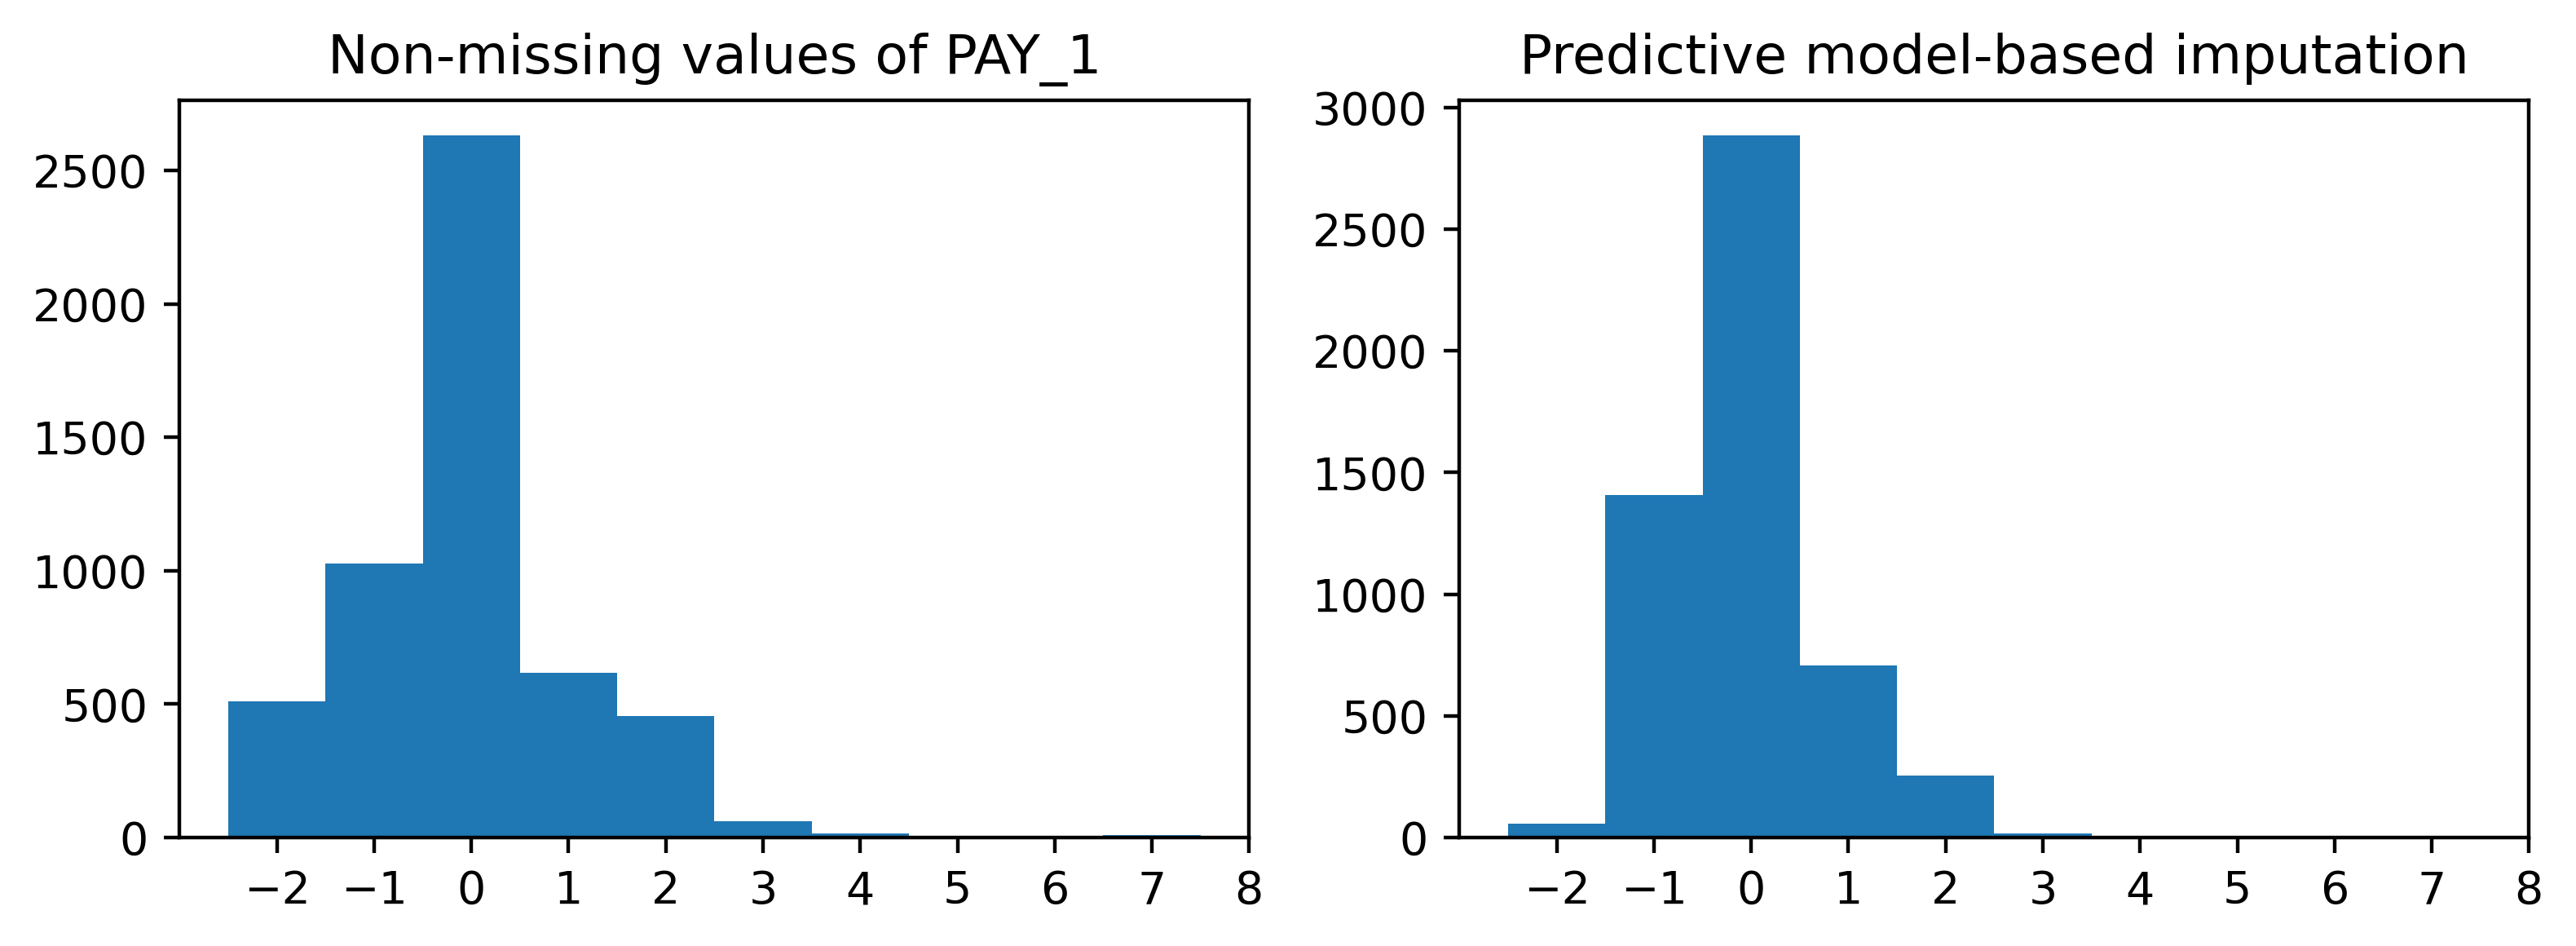

In [31]:
# plot values and predictions
fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Predictive model-based imputation')
plt.tight_layout()

It can be seen that the model predicts a lot of 0's, but also another values, which is better than only using the mode.

In [32]:
# colect data for the final imputation model
x_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [33]:
rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

In [34]:
rf_impute.fit(x_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12)

In [35]:
# veirfy missiong values
df_fill_pay_1_model = df_missing_pay_1.copy()
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [36]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [37]:
# verify all values
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      47
-1     757
 0    1645
 1     409
 2     154
 3       6
 5       1
 6       1
 8       1
Name: PAY_1, dtype: int64

In [40]:
x_fill_pay_1_train, x_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(df_fill_pay_1_model[features_response[:-1]].values,
                 df_fill_pay_1_model['default payment next month'].values,
                 test_size=0.2, random_state=24)

In [42]:
x_train_all = np.concatenate((x_train, x_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

In [44]:
# verifying rf
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [45]:
# use rf to compare model-based imputation
imputation_compare_cv = cross_validate(rf, x_train_all, y_train_all, scoring='roc_auc',
                                      cv=k_folds, n_jobs=-1, verbose=1,
                                      return_train_score=True, return_estimator=True,
                                      error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   43.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   43.8s finished


In [46]:
np.mean(imputation_compare_cv['test_score'])

0.7765713879850793

As the model using prediction is very similar to the one using the mode, the model used will be the more simple, using the mode to imput data. 

In [48]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)
df_fill_pay_1_model['PAY_1'].unique()

array([0], dtype=int64)

In [49]:
x_fill_pay_1_train, x_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(df_fill_pay_1_model[features_response[:-1]].values,
                df_fill_pay_1_model['default payment next month'].values,
                test_size=0.2, random_state=24)

In [51]:
x_train_all = np.concatenate((x_train, x_fill_pay_1_train), axis=0)
x_test_all = np.concatenate((x_test, x_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [52]:
imputation_compare_cv = cross_validate(rf, x_train_all, y_train_all, scoring='roc_auc',
                                      cv=k_folds, n_jobs=-1, verbose=1,
                                      return_train_score=True, return_estimator=True,
                                      error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   38.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   38.9s finished


In [53]:
np.mean(imputation_compare_cv['test_score'])

0.772866246168149